# ОИАД. Лабораторная работа №3

https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset?resource=download

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [54]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('insurance.csv')
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Наличие пропусков и выбросов:

In [55]:
print(df.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Пропусков в данных нет.

Выбросы по столбцам:

In [56]:
numeric = ['age', 'bmi', 'children', 'charges']

for col in numeric:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(col, ":", len(outliers))

age : 0
bmi : 9
children : 0
charges : 139


Привести категориальные признаки к числовым:

In [57]:
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

df['region'] = df['region'].map({
    'southwest': 0,
    'southeast': 1,
    'northwest': 2,
    'northeast': 3
})

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


Вычислить парные корреляции признаков:  
Нарисуем heatmap карту:

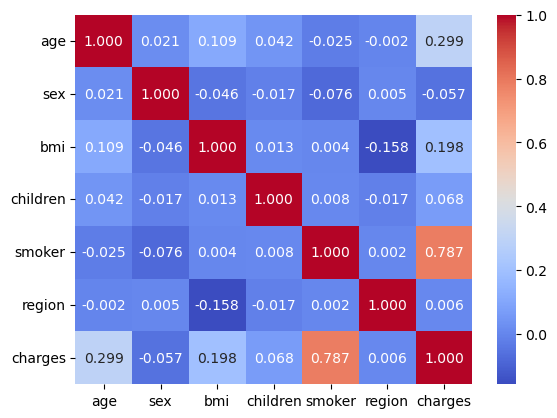

In [58]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".3f", cmap="coolwarm")
plt.show()


### Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)


Модель регрессии:  
$
f(x, w) = \sum_{i=1}^{n} w_i x_i = Xw
$

Функционал потерь:  
$
Q(w) = \sum_{i=1}^{\ell} (f(x_i, w) - y_i)^2 = ||Xw - y||^2 \rightarrow \min_{w} 
$

Градиент функционала потерь:  
$
\frac{\partial Q}{\partial w} = 2X^T(Xw-y)
$

Для поиска точки минимума, приравниваем градиент к нулю.  
$
2X^T(Xw-y) = 0
$

$
X^TXw = X^Ty
$

$
w^* = (X^TX)^{-1}X^Ty
$

In [59]:
import numpy as np

X = df.drop("charges", axis=1).values
y = df["charges"].values

X = np.hstack([np.ones((X.shape[0], 1)), X])

train_size = int(0.8 * len(df))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train

print("Параметры модели w*:")
print(w)

Параметры модели w*:
[-13356.4055305     259.91583957    246.70965668    334.50820583
    441.81651302  23631.78924739    437.18170076]


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y_pred_train = X_train @ w
y_pred_test = X_test @ w


mse_train = np.mean((y_train - y_pred_train)**2)
mse_test_lr = np.mean((y_test - y_pred_test)**2)

print("\nTrain MSE:", mse_train)
print("Test MSE:", mse_test_lr)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test_lr)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f"Train R²: {r2_train:.8f}, Test R²: {r2_test:.8f}")


Train MSE: 36385823.74461167
Test MSE: 37239419.48702374
Train RMSE: 6032.0662914636205
Test RMSE: 6102.410956910698
Train R²: 0.74850340, Test R²: 0.75807239


2. численно, с помощью методов градиентного спуска (реализовать самому)



$w^{(0)}$ - начальное приближение  
$\lambda$ - размер градиентного шага  

$w^{(k+1)} = w^{(k)} - \lambda \cdot \frac{\partial Q}{\partial w}|_{w=w^{(k)}}$  

Остановка просходит в случаях:
* градиент близок к нулю
* изменение параметров близко к нулю
* достигнуто ограничительное число итераций
  

In [61]:

alpha = 1e-7
max_iter = 1000000
tol = 1e-6


w = np.zeros(X_train.shape[1])

# Градиентный спуск
for i in range(max_iter):
    grad = 2 * X_train.T @ (X_train @ w - y_train)   # градиент
    w_1 = w - alpha * grad                          # шаг
    # проверка остановки
    if np.linalg.norm(w_1 - w) < tol:
        print(f"Остановились на итерации {i}")
        break
    if np.linalg.norm(grad) < tol:
        print(f"Остановились на итерации {i}")
        break
    w = w_1

print("Весa модели (градиентный спуск):")
print(w)


Весa модели (градиентный спуск):
[-13303.0315522     259.7040784     243.39965166    333.32627634
    440.93804807  23629.11666161    434.40878989]


In [62]:
# Предсказания
y_pred_train_gr = X_train @ w
y_pred_test_gr = X_test @ w

# Метрики
mse_train_gr = np.mean((y_train - y_pred_train_gr)**2)
mse_test_gr = np.mean((y_test - y_pred_test_gr)**2)
rmse_train_gr = np.sqrt(mse_train_gr)
rmse_test_gr = np.sqrt(mse_test_gr)
r2_train_gr = 1 - np.sum((y_train - y_pred_train_gr)**2)/np.sum((y_train - np.mean(y_train))**2)
r2_test_gr = 1 - np.sum((y_test - y_pred_test_gr)**2)/np.sum((y_test - np.mean(y_test))**2)

print("\n Метрики градиентного спуска")
print("\nTrain MSE:", mse_train_gr)
print("Test MSE:", mse_test_gr)
print(f"Train RMSE: {rmse_train_gr:.4f}, Test RMSE: {rmse_test_gr:.4f}")
print(f"Train R²: {r2_train_gr:.8f}, Test R²: {r2_test_gr:.8f}")




 Метрики градиентного спуска

Train MSE: 36385899.04113908
Test MSE: 37234665.75340976
Train RMSE: 6032.0725, Test RMSE: 6102.0214
Train R²: 0.74850288, Test R²: 0.75810328


### Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно


**Гребневая регрессия**  
$
Q_{L_2}(w) = ||Xw - y||^2 + \alpha ||w||_2^2 \rightarrow \min_{w}
$

Имеет аналитическое решение  
$
w^* = (X^TX + \alpha I)^{-1}X^Ty
$

где $I$ - единичная матрица


In [64]:
#1. аналитически

alpha = 10

# Единичная матрица
I = np.eye(X_train.shape[1])
I[0,0] = 0  # w0 не регуляризируем

w_ridge = np.linalg.inv(X_train.T @ X_train + alpha * I) @ X_train.T @ y_train

y_pred_train_ridge = X_train @ w_ridge
y_pred_test_ridge = X_test @ w_ridge

# Метрики
mse_train_ridge = np.mean((y_train - y_pred_train_ridge)**2)
mse_test_ridge = np.mean((y_test - y_pred_test_ridge)**2)
rmse_train_ridge = np.sqrt(mse_train_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
r2_train_ridge = 1 - np.sum((y_train - y_pred_train_ridge)**2)/np.sum((y_train - np.mean(y_train))**2)
r2_test_ridge = 1 - np.sum((y_test - y_pred_test_ridge)**2)/np.sum((y_test - np.mean(y_test))**2)

print("\nМетрики гребневой регрессии")
print("\nTrain MSE:", mse_train_ridge)
print("Test MSE:", mse_test_ridge)
print(f"Train RMSE: {rmse_train_ridge:.2f}, Test RMSE: {rmse_test_ridge:.2f}")
print(f"Train R²: {r2_train_ridge:.4f}, Test R²: {r2_test_ridge:.4f}")



Метрики гребневой регрессии

Train MSE: 36659176.30957565
Test MSE: 37937312.58960758
Train RMSE: 6054.68, Test RMSE: 6159.33
Train R²: 0.7466, Test R²: 0.7535


Численно:

Градиент будем вычислять по:
$$
\frac{\partial Q_{L_2}}{\partial w} = 2 X^T (Xw - y) + 2 \alpha w
$$


In [65]:
# Параметры градиентного спуска с регуляризацией
alpha_lr = 1e-7
max_iter = 1000000
tol = 1e-6
alpha_reg = 10

w_ridge_gr = np.zeros(X_train.shape[1])

for i in range(max_iter):
    grad = 2 * X_train.T @ (X_train @ w_ridge_gr - y_train) + 2 * alpha_reg * w_ridge_gr
    w_new = w_ridge_gr - alpha_lr * grad
    if np.linalg.norm(w_new - w_ridge_gr) < tol:
        print(f"Остановились на итерации {i}")
        break
    if np.linalg.norm(grad) < tol:
        print(f"Остановились на итерации {i} ")
        break
    
    w_ridge_gr = w_new

print("Весa модели (градиентный спуск с L2-регуляризацией):")
print(w_ridge_gr)


Весa модели (градиентный спуск с L2-регуляризацией):
[-9612.36661244   245.95988069   -29.54328429   257.9281311
   384.97095218 22189.03638359   263.1091172 ]


In [66]:

y_pred_train_gr = X_train @ w_ridge_gr
y_pred_test_gr = X_test @ w_ridge_gr


mse_train_gr = np.mean((y_train - y_pred_train_gr)**2)
mse_test_gr_L2 = np.mean((y_test - y_pred_test_gr)**2)
rmse_train_gr = np.sqrt(mse_train_gr)
rmse_test_gr = np.sqrt(mse_test_gr)
r2_train_gr = 1 - np.sum((y_train - y_pred_train_gr)**2) / np.sum((y_train - np.mean(y_train))**2)
r2_test_gr = 1 - np.sum((y_test - y_pred_test_gr)**2) / np.sum((y_test - np.mean(y_test))**2)

print("\nМетрики градиентного спуска с L2-регуляризацией")
print("\nTrain MSE:", mse_train_gr)
print("Test MSE:", mse_test_gr_L2)
print(f"Train RMSE: {rmse_train_gr:.4f}, Test RMSE: {rmse_test_gr:.4f}")
print(f"Train R²: {r2_train_gr:.8f}, Test R²: {r2_test_gr:.8f}")



Метрики градиентного спуска с L2-регуляризацией

Train MSE: 37022859.85092543
Test MSE: 37977695.45299421
Train RMSE: 6084.6413, Test RMSE: 6102.0214
Train R²: 0.74410024, Test R²: 0.75327615


#### Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

Константная модель:

In [68]:
y_mean = np.mean(y_train)
y_pred_test_const = np.full_like(y_test, y_mean)
mse_test_const = np.mean((y_test - y_pred_test_const)**2)

In [70]:
print("    Сравнение моделей по Test MSE")
print(f"Константная модель: {mse_test_const:.2f}")

print(f"Линейная регрессия: Аналитически {mse_test_lr:.2f}, Численно: {mse_test_gr:.2f}")
print(f"Регуляризованная L2: Аналитически {mse_test_ridge:.2f}, Численно: {mse_test_gr_L2:.2f}")


    Сравнение моделей по Test MSE
Константная модель: 154006942.59
Линейная регрессия: Аналитически 37239419.49, Численно: 37234665.75
Регуляризованная L2: Аналитически 37937312.59, Численно: 37977695.45


Константная модель показала очень большую MSE (154 млн), то есть просто прогноз среднего почти не подходит. Линейная регрессия без регуляризации дала наименьшую MSE на test (~ 37,2 млн), причём аналитическое и численное решения практически совпадают, что подтверждает корректность градиентного спуска. Ridge-регуляризация немного увеличила MSE (~ 37,9 млн) из-за сжатия весов